In [1]:
from math import sqrt

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import keras
from keras import models, layers, callbacks, constraints, backend, activations
from keras.callbacks import ModelCheckpoint, TensorBoard

from matplotlib import pyplot
import matplotlib.patches as mpatches

import datetime
import pathlib
import time
import json
import sys
import os

%matplotlib inline
pd.options.display.max_columns = None

/home/luis/anaconda3/envs/tensorflow-2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
"""
write

with open(data_file, 'wb') as dump:
    dump.write(json.dumps(arbitrary_data))

read

source = open(data_file, 'rb').read()
data = json.loads(source)
"""

"\nwrite\n\nwith open(data_file, 'wb') as dump:\n    dump.write(json.dumps(arbitrary_data))\n\nread\n\nsource = open(data_file, 'rb').read()\ndata = json.loads(source)\n"

In [3]:
def string_time(start, end):
    total = end - start
    hour = 60 * 60
    minute = 60
    
    num = total
    rem = num % hour
    
    hours = (num - rem) / hour

    num = rem
    rem = num % minute

    minutes = (num - rem) / minute
    
    return '{:.0f}:{:.0f}:{:.0f}'.format(hours, minutes, rem)

In [5]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)

    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test_scaled = scaler.transform(test)

    return scaler, train_scaled, test_scaled

In [6]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, y):
    
    # combine data back into single matrix for scaling
    features_and_labels_scaled = np.append(X, y, axis=1)
    features_and_labels = scaler.inverse_transform(features_and_labels_scaled)
    
    return features_and_labels

In [8]:
# fit an LSTM network to training data
def fit_nn(X_train, y_train, batch_size,
           nb_epochs, hidden_layers,
           X_validation = None, y_validation = None,
           loss = 'mean_squared_error',
           optimizer='adam',
           filepath = None):
    
    # training and testing
    # {neurons: number-neurons, dropout: 1.0, 0}
    # if dropout and recurrent_dropout are both 1 use CUDANNLSTM
    # if dropout and recurrent_dropout arethe same and not 1 use type 2 tied together
  
     # dropout
     # recurrent_dropout
     # implementation = 1,2
        
    model = models.Sequential()
    count = 1
               
    """
    keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                   bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
                   activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

    keras.layers.Dropout(rate, noise_shape=None, seed=None)

    """                       

    for i in range(len(hidden_layers)):

        layer = hidden_layers[i]
        lstm_type = 1
        return_seq = True

        if layer['dropout'] is layer['recurrent_dropout']:
            lstm_type = 2 

        if len(hidden_layers) is 1 or len(hidden_layers) - 1 is i:
            return_seq = False

        if i is 0: # first layer is different input shape must be known
            
            model.add(layers.Dense( 
                units = layer['neurons'],
                input_shape=(X_train.shape[1],),
#                 activation=None,
#                 use_bias=True,
#                 kernel_initializer='glorot_uniform',
#                 bias_initializer='zeros',
#                 kernel_regularizer=None,
#                 bias_regularizer=None,
#                 activity_regularizer=None,
#                 kernel_constraint=None,
#                 bias_constraint=None,
                name='hidden_layer_{}'.format(count)
            ))
            
            model.add(layers.Dropout(
                layer['dropout'],
#                 noise_shape=None,
#                 seed=None
            ))
            
        else: # last hidden layer does not return sequence

            model.add(layers.Dense( 
                units = layer['neurons'],
#                 activation=None,
#                 use_bias=True,
#                 kernel_initializer='glorot_uniform',
#                 bias_initializer='zeros',
#                 kernel_regularizer=None,
#                 bias_regularizer=None,
#                 activity_regularizer=None,
#                 kernel_constraint=None,
#                 bias_constraint=None,
                name='hidden_layer_{}'.format(count)
            ))
            
            model.add(layers.Dropout(
                layer['dropout'],
#                 noise_shape=None,
#                 seed=None
            ))
                     
    # output layer
    model.add(layers.Dense(
        units=y_train.shape[1],
        name='output_layer',
    ))
      
    model.compile(
        loss=loss,
        optimizer = optimizer
    )
    
    checkpoint_callback = ModelCheckpoint(filepath='{}/best_weights.hdf5'.format(filepath),
                                          verbose=0,
                                          save_best_only=True,
                                          save_weights_only=True
                                         )
    
    tb_callback = TensorBoard(log_dir='{}/logs/{}'.format(filepath,run_name),
                              batch_size=batch_size,
                              histogram_freq=1,
                              write_graph=True,
                              write_images=False)
    
    model.fit(
        X_train, 
        y_train, 
        epochs=nb_epochs, 
        batch_size=batch_size,
        verbose=0, 
        shuffle=True,
        validation_data=(X_validation, y_validation),
        callbacks=[checkpoint_callback, tb_callback] # tb_callback removed
    )
    
    # to save training rmse during training for plotting
#     rmse_dict = {'train_rmse': lstm_callback.losses, 'validation_rmse': lstm_callback.val_losses}
        
    return model

In [9]:
def make_model_online(feature_count, time_steps, nb_neurons, label_count, weights_file):
    batch_size = 1


    model = models.Sequential()

    count = 1

    if len(nb_neurons) > 1:

        first_LSTM_layer = nb_neurons[0]
        last_LSTM_layer = nb_neurons[-1]

        model.add(layers.LSTM(
            units=first_LSTM_layer,
            return_sequences=True,
            batch_input_shape=(batch_size, time_steps, feature_count), 
            stateful=True,
            name='LSTM_layer_{}'.format(count)
        ))

        count = count + 1

        for neurons in nb_neurons[1:-1]:

            model.add(layers.LSTM(
                units=neurons,
                return_sequences=True,
                stateful=True,
                name='LSTM_layer_{}'.format(count)
            ))

            count = count + 1

        model.add(layers.LSTM(
            units=last_LSTM_layer,
            stateful=True,
            name='LSTM_layer_{}'.format(count)
        ))



    else:

        model.add(layers.LSTM(
            units=nb_neurons[0],
            batch_input_shape=(batch_size, time_steps, feature_count), 
            stateful=True,
            name='LSTM_layer_{}'.format(count)
        ))

    model.add(layers.Dense(
        units=label_count,
        name='output_layer',
    #         kernel_constraint=constraints.non_neg()
    ))

    model.load_weights(weights_file)

    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
    )

    return model

In [10]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, axis=0, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [11]:
def plot_training_fit(y, yhat, labels, image_path=None):

    fig, axes = pyplot.subplots(len(labels), sharey = True, sharex = False)
    fig.set_figwidth(val=8)
    fig.set_figheight(val=20)

    for i in range(len(labels)):

        rmse = sqrt(mean_squared_error(y[:,i], yhat[:,i]))
        
        axes[i].set_title('{} RMSE: {:.2f}'.format(labels[i], rmse), fontsize=26, loc='right')
        axes[i].plot(y[:,i],label='actual')
        axes[i].plot(yhat[:,i] ,label='predicted')
        axes[i].legend(loc='upper center', bbox_to_anchor=(0.2, 1.13),  shadow=False, ncol=2)
        axes[i].set_xbound(0, 91)
        axes[i].autoscale(enable=True, tight=True)
#         axes[i].text(-1,110, 'RMSE {:.3f}'.format(rmse), fontsize=12, horizontalalignment='right', verticalalignment='top')
    
    pyplot.tight_layout(h_pad=.2, w_pad=.2)
    
    if image_path:
        pathlib.Path(image_path).mkdir(parents=True, exist_ok=True)
        pyplot.savefig('{}/fit_on_training.png'.format(image_path, labels[i].lower()), bbox_inches='tight')
    else:
        pyplot.show()

In [12]:
def plot_testing_fit(y, yhat, labels, mov_avg_size, image_path=None):

    for i in range(len(labels)):
        
        pyplot.rc('xtick', labelsize=35)
        pyplot.rc('ytick', labelsize=35)
        
        fig, axes = pyplot.subplots(1, sharey = True, sharex = False)
        fig.set_figwidth(val=40)
        fig.set_figheight(val=5)

        movavg = moving_average(yhat[:,i], mov_avg_size)

        start_avg = np.full(mov_avg_size - 1, movavg[0])

        movavg = np.append(start_avg, movavg)

        rmse = sqrt(mean_squared_error(y[:,i], movavg))

        axes.plot(y[:,i] ,label='actual')
        axes.plot(movavg, label='predicted')
        legend = axes.legend(loc='upper center', bbox_to_anchor=(0.18, 1.5),  shadow=False, ncol=4, prop={'size': 45})
        
        for line in legend.get_lines():
            line.set_linewidth(5)
        
#         axes[i].set_title(labels[i], fontsize=26, loc='left')
        axes.set_title('{} RMSE: {:.2f}'.format(labels[i], rmse), fontsize=60, loc='center')
        axes.set_xbound(0, 3550)
#         axes[i].set_xlabel('RING', fontsize=16)
#         axes[i].set_ylabel('VALUE', fontsize=16)
#         axes[i].text(1, -20, 'RMSE {:.3f}'.format(rmse), fontsize=16)

        

     # get the individual lines inside legend and set line width
        for line in axes.get_lines():
            line.set_linewidth(5)
        
        axes.autoscale(enable=True, tight=True)
        pyplot.tight_layout(h_pad=.2, w_pad=.2)
    
        if image_path:
            pathlib.Path(image_path).mkdir(parents=True, exist_ok=True)
            pyplot.savefig('{}/{}_fit_on_testing.png'.format(image_path, labels[i].lower()), bbox_inches='tight')
            pyplot.close('all')
        else:
            pyplot.show()

In [13]:
def plot_stack(y, yhat, labels, mov_avg_size, image_path=None):

    Y1 = y.transpose()
    Y2 = yhat.transpose()

    Y3 = moving_average(yhat, mov_avg_size)
    start_Y3 = np.full((mov_avg_size - 1, 4), Y3[0])
    Y3 = np.append(start_Y3, Y3, axis=0).transpose()
    
    
    
    # copy to display normalized values
    Y4 = np.copy(Y3)
    
    # zero negative predictions
    Y4[Y4 < 0] = 0
    
    sums = Y4[0,:]
    
    for i in range(1, len(labels)):
        sums = sums + Y4[i,:]
    
    # normalize and rescale
    Y4 = np.divide(Y4, sums) * 100

    raw_path = '{}/{}'.format(image_path, 'raw')
    moving_avg_path = '{}/{}'.format(image_path, 'moving_avg')
    normalized_path = '{}/{}'.format(image_path, 'normalized')
    
    plot_testing_fit(Y1.transpose(), Y2.transpose(), labels, 1, raw_path)
    plot_testing_fit(Y1.transpose(), Y3.transpose(), labels, 1, moving_avg_path)
    plot_testing_fit(Y1.transpose(), Y4.transpose(), labels, 1, normalized_path)
    
    rmse = sqrt(mean_squared_error(Y1, Y4))
    print(rmse)

    YS = [Y1, Y2, Y3, Y4]
    labs = ['VALUES', 'RAW PRED', 'MOVING AVG PRED', 'PREDICTIONS']
    paths = [image_path, raw_path, moving_avg_path, normalized_path]
    X = np.arange(1, y.shape[0] + 1, 1)

    for i in range(len(YS)):
        
        pyplot.rc('xtick', labelsize=35)
        pyplot.rc('ytick', labelsize=35)
    
        fig, axes = pyplot.subplots(1, sharey = True, sharex = False)
        fig.set_figwidth(val=40)
        fig.set_figheight(val=5)

        axes.stackplot(X, YS[i], labels=labels, baseline='zero')
        axes.axis('tight')
        axes.legend(loc='upper center', bbox_to_anchor=(0.18, 1.5),  shadow=False, ncol=4, prop={'size': 45})
        
        axes.set_title(labs[i],fontsize=60, loc='center')
        axes.set_xbound(0, 3550)
        axes.set_ybound(-0.07)
        
        axes.autoscale(enable=True, tight=True)
        pyplot.tight_layout(h_pad=.2, w_pad=.2)
            
        if image_path:
            pathlib.Path(image_path).mkdir(parents=True, exist_ok=True)
            pyplot.savefig('{}/{}_stack_plot.png'.format(paths[i], labs[i].lower()), bbox_inches='tight')
            pyplot.close('all')
        else:
            pyplot.show()

In [14]:
def plot_learn(training_errors_dict, image_path, single_model=False):
    
    trains = np.array(training_errors_dict['train_rmse'])
    trains = trains.transpose()
   #  plot_learn({'train' : [rmse_dict['train_rmse']], 'test' : [rmse_dict['validation_rmse']]}, run_folder, True)
    tests = np.array(training_errors_dict['validation_rmse'])
    tests = tests.transpose()
    
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    
    pyplot.title('RMSE',fontsize=18, loc='center')
    
    pyplot.plot(trains, label=[],color='goldenrod')
    pyplot.plot(tests, label=[], color='coral')

    val_patch = mpatches.Patch(color='goldenrod', label='train_loss')
    train_patch = mpatches.Patch(color='coral', label='val_loss')
    
    if not single_model:   
    
        median_train = np.median(trains,axis=1)
        median_test = np.median(tests,axis=1)

        mean = np.array([np.mean(trains,axis=1), np.mean(tests,axis=1)])
        mean = mean.transpose()

        median = np.array([np.median(trains,axis=1), np.median(tests,axis=1)])
        median = median.transpose()

        pyplot.plot(mean, label=[],color='blueviolet')
        pyplot.plot(median, label=[],color='black')

        mean_patch = mpatches.Patch(color='blueviolet', label='mean')
        median_patch = mpatches.Patch(color='black', label='median')

        pyplot.legend(ncol = 2, handles=[val_patch, train_patch, median_patch, mean_patch])
    
    else:
        pyplot.legend(ncol = 2, handles=[val_patch, train_patch])
        
            
#     axes.autoscale(enable=True, tight=True)
    pyplot.tight_layout(h_pad=.2, w_pad=.2)
        
        
    pathlib.Path(image_path).mkdir(parents=True, exist_ok=True)
    pyplot.savefig('{}/learn_curve.png'.format(image_path), bbox_inches='tight')

In [15]:
def experiment(train, test, labels, pca_features, repeats=2, 
               time_steps=3, hidden_layers=[], nb_epochs=100,
               batch_size=1, val_size=100, mov_avg_size=1, save_folder='temp'):
    
    info_dict = {}
    info_dict['hidden_layers'] = hidden_layers
    info_dict['time_steps'] = time_steps
    info_dict['labels'] = labels
    info_dict['pca_features'] = pca_features
    info_dict['repeats'] = repeats
    info_dict['nb_epochs'] = nb_epochs
    info_dict['batch_size'] = batch_size
    info_dict['mov_avg_size'] = mov_avg_size
    info_dict['val_size'] = val_size
    
    hl = []
    for layers in hidden_layers:
        hl.append(layers['neurons'])
    

    # runs for this experement are saved
    runs_folder = 'ts_{}_pca_{}_ep_{}_bs_{}_hl_{}_{}'.format(time_steps,
                                                             pca_features,
                                                             nb_epochs,
                                                             batch_size,
                                                             hl,
                                                             datetime.datetime.now().strftime('%Y%m%d_%H-%M'))
    
    print(runs_folder)
    
    path = '{}/{}'.format(save_folder,runs_folder)
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    runs_path = '{}/runs'.format(path)
    pathlib.Path(runs_path).mkdir(parents=True, exist_ok=True)
    
    with open('{}/info.json'.format(path), 'w') as dump:
        dump.write(json.dumps(info_dict))
    
    
    # split features away for PCA
    X_train = train.drop(labels, axis=1)
    X_test = test.drop(labels, axis=1)

    y_train = train[labels]
    y_test = test[labels]
    
    # PCA
    pca_model = PCA(n_components = pca_features)
    pca_model = pca_model.fit(X_train)
    X_train = pca_model.transform(X_train)
    X_test = pca_model.transform(X_test)
    
    # transform data for LSTM supervised learning
    reframed_X_train = series_to_supervised(X_train, time_steps, 0)
    reframed_X_train = reframed_X_train.reset_index().drop(['index'], axis=1)

    reframed_y_train = y_train.shift(time_steps).dropna()
    reframed_y_train = reframed_y_train.reset_index().drop(['index'], axis=1)

    reframed_X_test = series_to_supervised(X_test, time_steps, 0)
    reframed_X_test = reframed_X_test.reset_index().drop(['index'], axis=1)

    reframed_y_test = y_test.shift(time_steps).dropna()
    reframed_y_test = reframed_y_test.reset_index().drop(['index'], axis=1)
    
    # combine data for scaling
    train_for_scaling = pd.concat([reframed_X_train, reframed_y_train], axis=1).values
    test_for_scaling = pd.concat([reframed_X_test, reframed_y_test], axis=1).values
    
    # fit for correct batch size
    to_remove = train_for_scaling.shape[0] % batch_size
    
    if to_remove > 0:
        train_for_scaling = train_for_scaling[:-to_remove, :]

    to_remove = test_for_scaling.shape[0] % batch_size
    
    if to_remove > 0:
        test_for_scaling = test_for_scaling[:-to_remove, :]
    
    
    # scale data
    scaler, scaled_train, scaled_test = scale(train_for_scaling, test_for_scaling)
    
    # split data back into train and test
    label_count = len(labels)
    X_train, y_train = scaled_train[:, :-label_count], scaled_train[:, -label_count:]
    X_test, y_test = scaled_test[:, :-label_count], scaled_test[:, -label_count:]
    
    # save scaled features to inverse results later
    X_train_scaled = np.copy(X_train)
    X_test_scaled = np.copy(X_test)

    # reshape for input into LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], time_steps, pca_features))
    X_test = np.reshape(X_test, (X_test.shape[0], time_steps, pca_features))
    
    val_size = val_size - (val_size % batch_size)
    
    error_scores = {'train' : [], 'test' : [], 'test_normalized': []}
    
    training_epoch_error_scores = {'train_rmse' : [], 'validation_rmse' : []}
    
    for r in range(repeats):
        
        # this is were models is saved as JSON and weights of model as HDF5
        run_folder = '{}/run_{}'.format(runs_path, r + 1)
        pathlib.Path(run_folder).mkdir(parents=True, exist_ok=True)
        
        start = time.time()
        
        if val_size is None:
            # fit an LSTM network to training data without validation is not used
            rmse_dict, model = fit_lstm(X_train, y_train, batch_size, nb_epochs, hidden_layers)
 
            training_epoch_error_scores['train_rmse'].append(rmse_dict['train_rmse'])

        else:
            # fit an LSTM network to training data with validation
            rmse_dict, model = fit_lstm(X_train, y_train, batch_size, nb_epochs, hidden_layers, X_test[:val_size], y_test[:val_size], run_folder)
            
            training_epoch_error_scores['train_rmse'].append(rmse_dict['train_rmse'])
            training_epoch_error_scores['validation_rmse'].append(rmse_dict['validation_rmse'])     
        
        with open('{}/model.json'.format(run_folder), 'w') as json_file:
            json_file.write(model.to_json()) # serialize model to JSON
            json_file.close()
        
        model.save_weights('{}/weights.hdf5'.format(run_folder)) # serialize weights to HDF5
        
        # plot individual learn rates
        plot_learn(rmse_dict, run_folder, True)
        
        # forecast the entire training dataset to build up state for forecasting
        train_predict = model.predict(X_train, batch_size=batch_size)
        
        # scale training predictions back
        features_and_prediction = invert_scale(scaler, X_train_scaled, train_predict)
        y = train_for_scaling[:,-4:]
        yhat = features_and_prediction[:,-4:]
        
        # get rmse for training data
        rmse = sqrt(mean_squared_error(y, yhat))
        error_scores['train'].append(rmse)
        
        # this is were fit on training is saved
        plot_training_fit(y, yhat, labels, run_folder)
        
        # for next image / moving avg
        train_y = np.copy(y)
        train_yhat = np.copy(yhat)
     
        # forecast test dataset
        test_predict = model.predict(X_test, batch_size=batch_size)
        
        # scale testing predictions back
        features_and_prediction = invert_scale(scaler, X_test_scaled, test_predict)
        test_y = test_for_scaling[:,-4:]
        test_yhat = features_and_prediction[:,-4:]
        
        # get rmse for testing data
        rmse = sqrt(mean_squared_error(test_y, test_yhat))
        error_scores['test'].append(rmse)
    
        combined_y = np.append(train_y, test_y, axis=0)
        combined_yhat = np.append(train_yhat, test_yhat, axis=0)
        
        # get rmse data for testing with moving average smoothing 
        test_normal = test_normalized(combined_yhat, test_yhat.shape[0], mov_avg_size)
        rmse = sqrt(mean_squared_error(test_y, test_normal))
        error_scores['test_normalized'].append(rmse)
    
        # this is were stack plot image is saved and fit on testing is saved
        plot_stack(combined_y, combined_yhat, labels, mov_avg_size, run_folder)
        
        pyplot.close('all')
        
        # print rmse
        print('{} Train RMSE: {:.2f}, Test RMSE: {:.2f}, Test_Normalized RMSE: {:.2f}, Time: {}'.format(r + 1,
                                                                          error_scores['train'][r],
                                                                          error_scores['test'][r],
                                                                          error_scores['test_normalized'][r],
                                                                          string_time(start, time.time())))
    # this is were learn rate is saved
    plot_learn(training_epoch_error_scores, path)
    pyplot.close('all')
    
    # this is were error_scores are saved for future plotting
    column_name = 'ts{}-pca{}-ne{}-nn{}-bs{}'.format(time_steps, pca_features, nb_epochs, hidden_layers, batch_size)


    training_epoch_rmse_score = pd.DataFrame(training_epoch_error_scores['train_rmse'])
    training_epoch_rmse_score.to_csv('{}/training_epoch_rmse_scores.csv'.format(path), index=False)
    
    validation_epoch_rmse_score = pd.DataFrame(training_epoch_error_scores['validation_rmse'])
    validation_epoch_rmse_score.to_csv('{}/validation_epoch_rmse_scores.csv'.format(path), index=False)
    
    test_normalized_results = pd.DataFrame()
    test_normalized_results[column_name] = error_scores['test_normalized']
    test_normalized_results.to_csv('{}/test_normalized.csv'.format(path), index=False)
    
    test_results = pd.DataFrame()
    test_results[column_name] = error_scores['test']
    test_results.to_csv('{}/test_results.csv'.format(path), index=False)
    
    train_results = pd.DataFrame()
    train_results[column_name] = error_scores['train']
    train_results.to_csv('{}/train_results.csv'.format(path), index=False)

In [16]:
def test_normalized(combined_yhat, test_size, mov_avg_size):
    
    y_hat = np.copy(combined_yhat)
    
    # zero negative predictions
    y_hat[y_hat < 0] = 0
    
    # get moving average
    y_hat = moving_average(y_hat, mov_avg_size)
    
    y_hat = y_hat.transpose()

    sums = y_hat[0,:]
    
    for i in range(1, len(labels)):
        sums = sums + y_hat[i,:]
    
    # normalize and rescale
    y_hat = np.divide(y_hat, sums) * 100
    
    y_hat = y_hat.transpose()
    
    y_hat= y_hat[-test_size:,:]
    
    return y_hat

In [17]:
def generate_boxplots(save_folder = 'temp'):

    folders = os.listdir(save_folder)
    
    training_df_list = []
    testing_df_list = []
    testing_smoothed_df_list = []
    
    for folder in folders:
        
        path = '{}/{}'.format(save_folder,folder)
        
        
        if os.path.isdir(path):
        
            training_df_list.append(pd.read_csv(path + '/train_results.csv'))
            testing_df_list.append(pd.read_csv(path + '/test_results.csv'))
            testing_smoothed_df_list.append(pd.read_csv(path + '/test_smoothed_results.csv'))
        
    df_training = pd.concat(training_df_list, axis=1, ignore_index=False)
    df_testing = pd.concat(testing_df_list, axis=1, ignore_index=False)
    df_testing_smoothed = pd.concat(testing_smoothed_df_list, axis=1, ignore_index=False)

    
    pyplot.boxplot(df_training.values, labels=df_training.columns)
    pyplot.xticks(rotation='vertical')
    pyplot.title('train_results')
    pyplot.autoscale(enable=True, tight=True)
    
    pyplot.show()
#     pyplot.savefig('{}/boxplot_training.png'.format(save_folder), bbox_inches='tight') 
    
    pyplot.boxplot(df_testing.values, labels=df_testing.columns)
    pyplot.xticks(rotation='vertical')
    pyplot.title('test_results')
    pyplot.autoscale(enable=True, tight=True)
    
    pyplot.show()
#     pyplot.savefig('{}/boxplot_testing.png'.format(save_folder), bbox_inches='tight') 
    
    pyplot.boxplot(df_testing_smoothed.values, labels=df_testing_smoothed.columns)
    pyplot.xticks(rotation='vertical')
    pyplot.title('test_smoothed_results')
    pyplot.autoscale(enable=True, tight=True)
    
    pyplot.show()
#     pyplot.savefig('{}/boxplot_testing_smoothed.png'.format(save_folder), bbox_inches='tight') 

#     pyplot.close('all')

In [18]:
# write a function that a list of tuples in form of (time_steps, pca_features, nb_epochs, nb_neurons, batch_size)
def lstm_tuning(train, test, labels, list_of_tuples, repeats, val_size, mov_avg_size, save_folder):
    
    for (time_steps, pca_features, nb_epochs, hidden_layers, batch_size) in list_of_tuples:
        experiment(train, test, labels, pca_features,
                   repeats, time_steps, hidden_layers,
                   nb_epochs, batch_size, val_size,
                   mov_avg_size, save_folder)

In [19]:
# REDO priority low
def load_models_test(train, test, labels, pca_features, mov_avg_size=1, save_folder='temp', best_weights=True):
    
    folders = os.listdir(save_folder)
    
    for folder in folders:
        
        path = '{}/{}'.format(save_folder,folder)
#         print('path: {}, isdir: {}'.format(path, os.path.isdir(path)))
        
        if os.path.isdir(path):
            
            path = path + '/runs'
#             print('path: {}, isdir: {}'.format(path, os.path.isdir(path)))
            
            runs = os.listdir(path)
            for run in runs:
            
                model_file = '{}/{}/model.json'.format(path,run)
                
                if best_weights:
                    weight_file = '{}/{}/best_weights.hdf5'.format(path,run)
                else:
                    weight_file = '{}/{}/weights.hdf5'.format(path,run)
                
#                 print('path: {}, isfile: {}'.format(model_file, os.path.isfile(model_file)))
#                 print('path: {}, isfile: {}'.format(weight_file, os.path.isfile(weight_file)))

                json_file = open(model_file, 'r')
                loaded_model_json = json_file.read()
                json_file.close()
                loaded_model = model_from_json(loaded_model_json)
                # load weights into new model
                loaded_model.load_weights(weight_file)
                print("Loaded model from disk")

In [20]:
def make_model_online(feature_count, time_steps, nb_neurons, label_count, weights_file):
    batch_size = 1


    model = models.Sequential()

    count = 1

    if len(nb_neurons) > 1:

        first_LSTM_layer = nb_neurons[0]
        last_LSTM_layer = nb_neurons[-1]

        model.add(layers.LSTM(
            units=first_LSTM_layer,
            return_sequences=True,
            batch_input_shape=(batch_size, time_steps, feature_count), 
            stateful=True,
            name='LSTM_layer_{}'.format(count)
        ))

        count = count + 1

        for neurons in nb_neurons[1:-1]:

            model.add(layers.LSTM(
                units=neurons,
                return_sequences=True,
                stateful=True,
                name='LSTM_layer_{}'.format(count)
            ))

            count = count + 1

        model.add(layers.LSTM(
            units=last_LSTM_layer,
            stateful=True,
            name='LSTM_layer_{}'.format(count)
        ))



    else:

        model.add(layers.LSTM(
            units=nb_neurons[0],
            batch_input_shape=(batch_size, time_steps, feature_count), 
            stateful=True,
            name='LSTM_layer_{}'.format(count)
        ))

    model.add(layers.Dense(
        units=label_count,
        name='output_layer',
    #         kernel_constraint=constraints.non_neg()
    ))

    model.load_weights(weights_file)

    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
    )

    return model

In [21]:
"""
# timesteps_3_pca_50_epochs_200_nodes_[400]_batch_size_2
mov_avg_size = 1
pca_features = 65
time_steps = 3
nb_neurons = [75,50,25]
label_count = 4
weights_path = 'test_5/timesteps_3_pca_65_epochs_500_nodes_[75, 50, 25]_batch_size_2/runs/run_9'
weights_file = '{}/model.h5'.format(weights_path)
"""

"\n# timesteps_3_pca_50_epochs_200_nodes_[400]_batch_size_2\nmov_avg_size = 1\npca_features = 65\ntime_steps = 3\nnb_neurons = [75,50,25]\nlabel_count = 4\nweights_path = 'test_5/timesteps_3_pca_65_epochs_500_nodes_[75, 50, 25]_batch_size_2/runs/run_9'\nweights_file = '{}/model.h5'.format(weights_path)\n"

In [22]:
"""
model_loaded_w = make_model_online(pca_features, time_steps, nb_neurons, label_count, weights_file)
"""

'\nmodel_loaded_w = make_model_online(pca_features, time_steps, nb_neurons, label_count, weights_file)\n'

In [23]:
pca_features = 50

In [24]:
train_dataset = pd.DataFrame.from_csv('../dataset/train.csv', index_col=None)
test_dataset = pd.DataFrame.from_csv('../dataset/test.csv', index_col=None)

labels = ['Cover_Type'] # labels

"""
"""

X_train = train.drop(labels, axis=1)
X_test = test.drop(labels, axis=1)

y_train = train[labels]
y_test = test[labels]

# PCA
pca_model = PCA(n_components = pca_features)
pca_model = pca_model.fit(X_train)

X_train = pca_model.transform(X_train)
X_test = pca_model.transform(X_test)


# combine data for scaling
train_for_scaling = pd.concat([reframed_X_train, reframed_y_train], axis=1).values
test_for_scaling = pd.concat([reframed_X_test, reframed_y_test], axis=1).values

# scale data
scaler, scaled_train, scaled_test = scale(train_for_scaling, test_for_scaling)

# split data back into train and test
label_count = len(labels)
X_train, y_train = scaled_train[:, :-label_count], scaled_train[:, -label_count:]
X_test, y_test = scaled_test[:, :-label_count], scaled_test[:, -label_count:]

# save scaled features to inverse results later
X_train_scaled = np.copy(X_train)
X_test_scaled = np.copy(X_test)

# reshape for input into LSTM
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, pca_features))
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, pca_features))

/home/luis/anaconda3/envs/tensorflow-2/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':
/home/luis/anaconda3/envs/tensorflow-2/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  from ipykernel import kernelapp as app


In [25]:
X_validation = X_test[:100]
y_validation = y_test[:100]

In [26]:
# mov_avg_size = 21
# pca_features = 65
# label_count = 4
# repeats = 2
# time_steps=3
# batch_size = 1
# nb_epochs = 10
# hidden_layers = [
#     {'neurons': 100, 'dropout': 1.0, 'recurrent_dropout': 1.0},
#     {'neurons': 80, 'dropout': 1.0, 'recurrent_dropout': 1.0},
#     {'neurons': 60, 'dropout': 1.0, 'recurrent_dropout': 1.0},
# ]

# save_folder='test'

In [27]:
l_1 = [
    {'neurons': 100, 'dropout': 1.0, 'recurrent_dropout': 1.0},
    {'neurons': 80, 'dropout': 1.0, 'recurrent_dropout': 1.0},
    {'neurons': 60, 'dropout': 1.0, 'recurrent_dropout': 1.0},
]

l_2 = [
    {'neurons': 100, 'dropout': 0.8, 'recurrent_dropout': 1.0},
    {'neurons': 80, 'dropout': 0.8, 'recurrent_dropout': 1.0},
    {'neurons': 60, 'dropout': 0.8, 'recurrent_dropout': 1.0},
]

l_3 = [
    {'neurons': 100, 'dropout': 1.0, 'recurrent_dropout': 0.8},
    {'neurons': 80, 'dropout': 1.0, 'recurrent_dropout': 0.8},
    {'neurons': 60, 'dropout': 1.0, 'recurrent_dropout': 0.8},
]

l_4 = [
    {'neurons': 100, 'dropout': 0.8, 'recurrent_dropout': 0.8},
    {'neurons': 80, 'dropout': 0.8, 'recurrent_dropout': 0.8},
    {'neurons': 60, 'dropout': 0.8, 'recurrent_dropout': 0.8},
]

layer_neurons = [l_1,l_2,l_3,l_4]

In [28]:
# test

pca_features = [50] # from PCA
time_steps = [3] # time dimension
hidden_layers = layer_neurons # number of neurons
nb_epochs = [200] # training epoch
batch_size = [1] # number passes before updating wieghts

# (time_steps, pca_features, nb_epochs, nb_neurons, batch_size)
list_of_tuples = [(a,b,c,d,e) for a in time_steps for b in pca_features for c in nb_epochs 
                  for d in hidden_layers for e in batch_size]

In [29]:
train = boreholerings_dataset.drop('Ring#', axis=1) 
test = allrings_dataset.loc[booleans].drop('Ring#', axis=1)
labels = ['TLD', 'CCS', 'CSF', 'CSG'] # labels

completed = 0
list_of_tuples = list_of_tuples[completed:]

repeats = 1 # how many times to make model with same params
val_size = 200 # validation size during training goes to nearest batch size
mov_avg_size = 23 # moving avg smoothing for images



In [30]:
# save_folder = 'test-tuning'
# lstm_tuning(train, test, labels, list_of_tuples, repeats, val_size, mov_avg_size, save_folder)

In [31]:
save_folder = 'test-single'
rmse_dict, model = fit_lstm(X_train, y_train, batch_size = batch_size[0],
                            nb_epochs = nb_epochs[0], hidden_layers = l_1,
                            X_validation = X_validation,
                            y_validation = y_validation,
                            filepath = save_folder)

In [32]:
train_yhat =  model.predict(X_train, batch_size = 1)
test_yhat = model.predict(X_test, batch_size = 1)

In [33]:
features_and_prediction = invert_scale(scaler, X_train_scaled, train_yhat)
train_y = test_for_scaling[:,-4:]
train_yhat = features_and_prediction[:,-4:]

In [34]:
features_and_prediction = invert_scale(scaler, X_test_scaled, test_yhat)
test_y = test_for_scaling[:,-4:]
test_yhat = features_and_prediction[:,-4:]

In [35]:
combined_y = np.append(y_train, y_test, axis=0)
combined_yhat = np.append(train_yhat, test_yhat, axis=0)
                

In [36]:
test_normal = test_normalized(combined_yhat, test_yhat.shape[0], mov_avg_size)

29.315757170048773


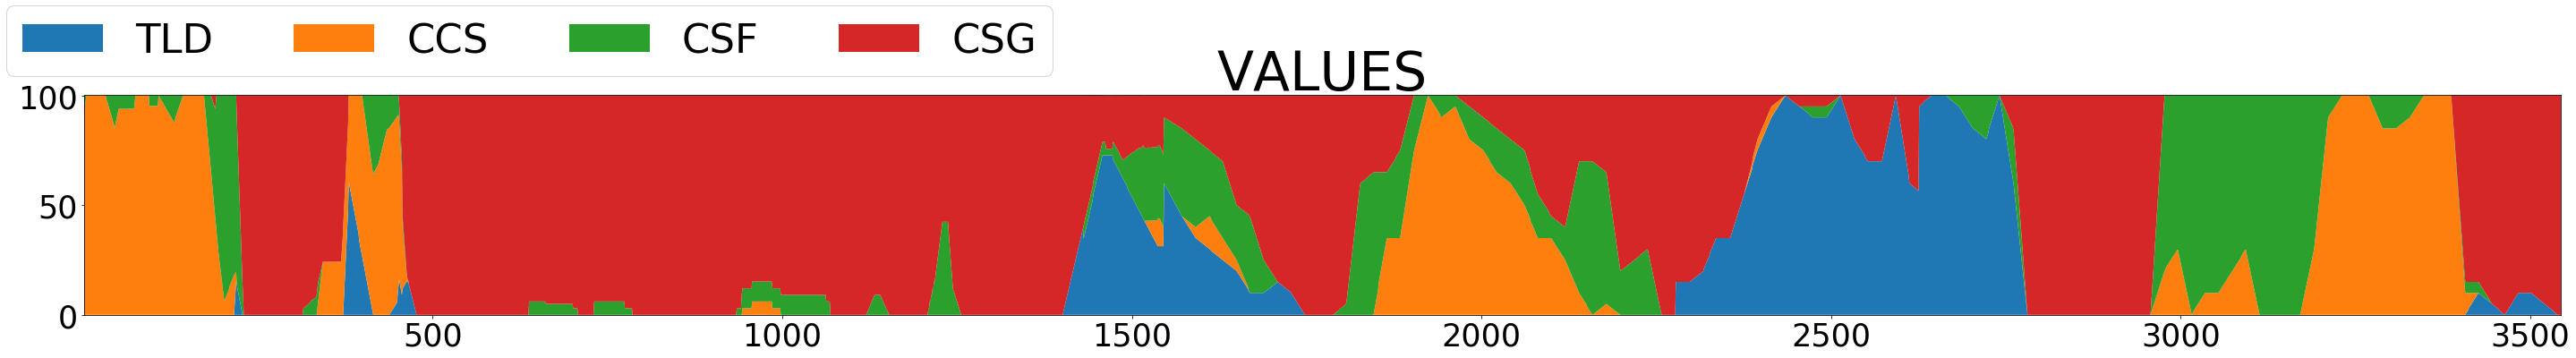

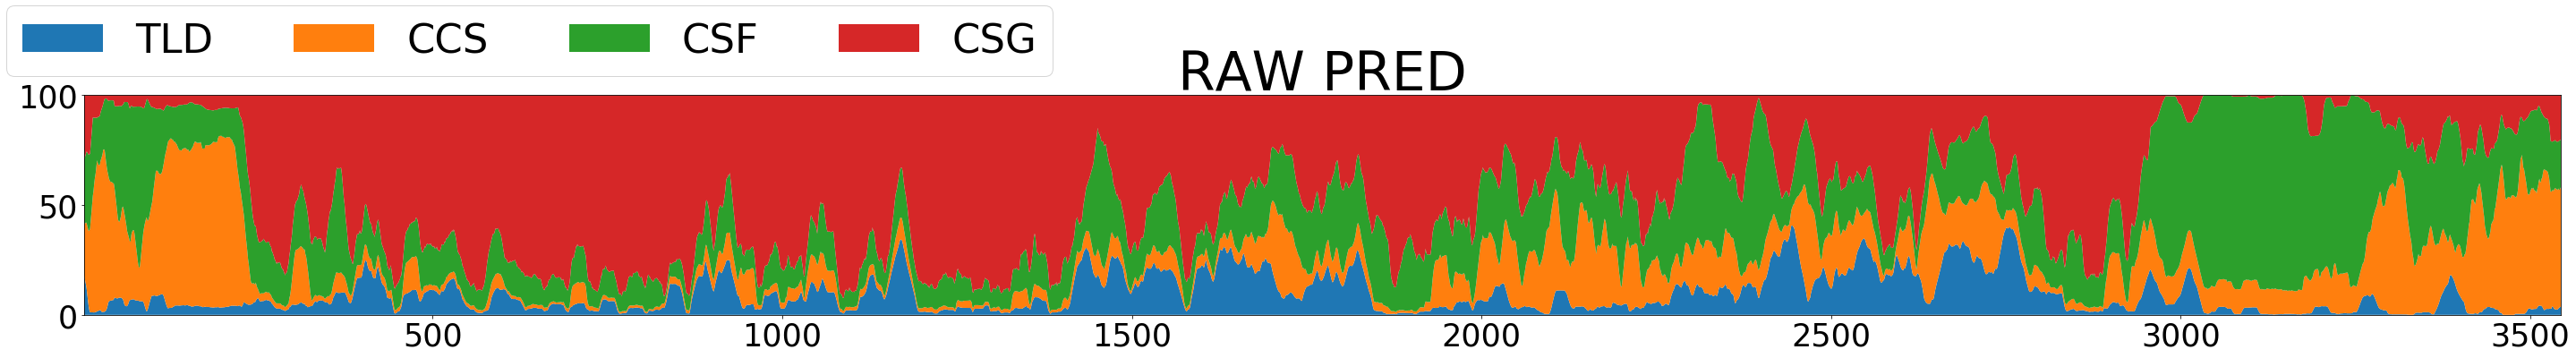

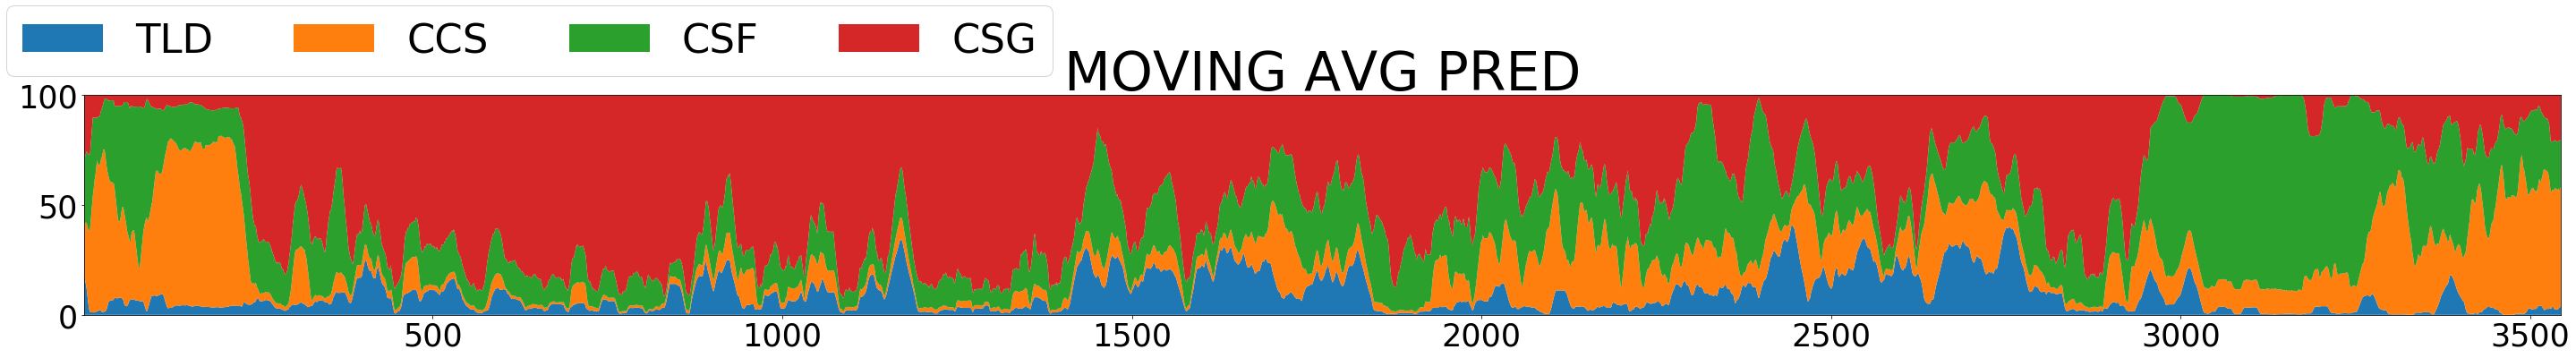

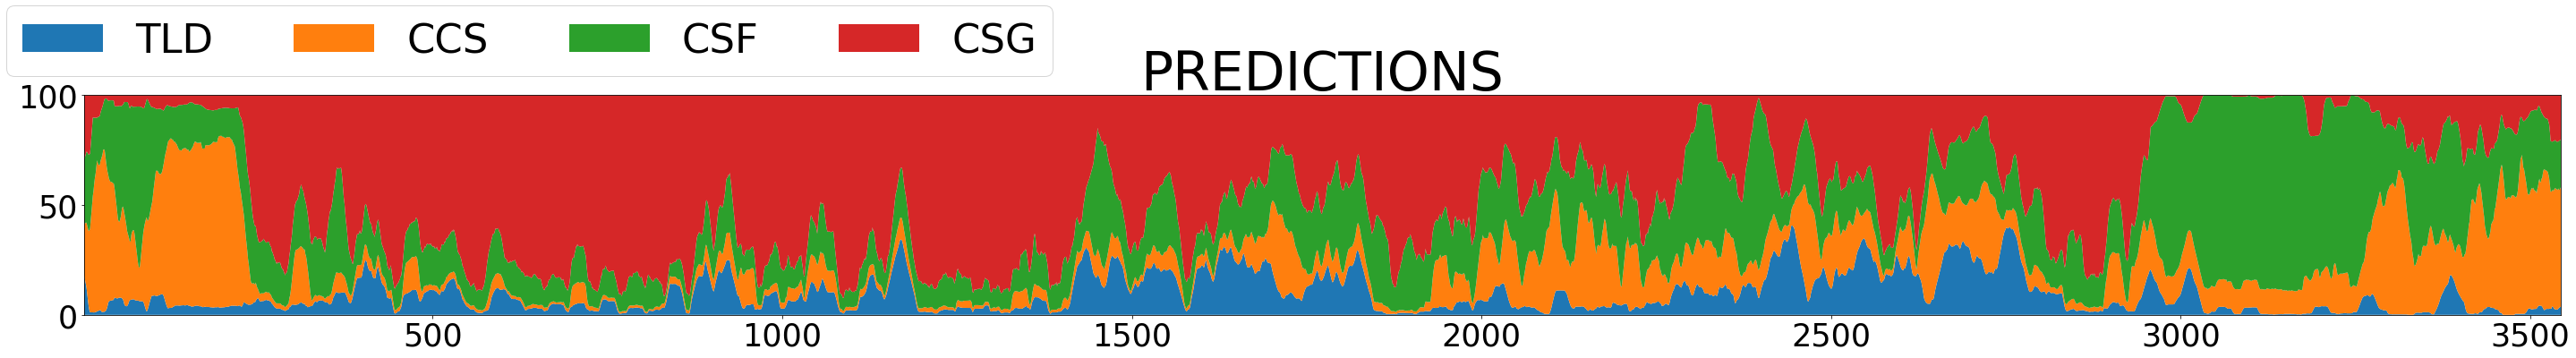

In [37]:
plot_stack(test_y, test_normal, labels, 1, image_path=None)

In [38]:
from sklearn.metrics import explained_variance_score
print(explained_variance_score(test_y[:,0], test_normal[:,0]))
print(explained_variance_score(test_y[:,1], test_normal[:,1]))
print(explained_variance_score(test_y[:,2], test_normal[:,2]))
print(explained_variance_score(test_y[:,3], test_normal[:,3]))
print(explained_variance_score(test_y, test_normal))

0.2943870515776067
0.13481423292011674
0.21716028467774717
0.35791775580967344
0.25106983124628657


In [39]:
from sklearn.metrics import median_absolute_error
print(median_absolute_error(test_y[:,0], test_normal[:,0]))
print(median_absolute_error(test_y[:,1], test_normal[:,1]))
print(median_absolute_error(test_y[:,2], test_normal[:,2]))
print(median_absolute_error(test_y[:,3], test_normal[:,3]))
# print(median_absolute_error(test_y, test_normal))

5.993592710701897
10.9881506524901
16.15334779182357
22.242903918671296


In [40]:
from sklearn.metrics import r2_score
print(r2_score(test_y[:,0], test_normal[:,0]))
print(r2_score(test_y[:,1], test_normal[:,1]))
print(r2_score(test_y[:,2], test_normal[:,2]))
print(r2_score(test_y[:,3], test_normal[:,3]))
print(r2_score(test_y, test_normal))

0.26507253892521987
0.13276643451766657
-0.09994922847096355
0.32785075021123156
0.15643512379578936


In [42]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(test_y[:,0], test_normal[:,0]))
print(mean_squared_error(test_y[:,1], test_normal[:,1]))
print(mean_squared_error(test_y[:,2], test_normal[:,2]))
print(mean_squared_error(test_y[:,3], test_normal[:,3]))
print(mean_squared_error(test_y, test_normal))

599.9276995169574
959.5492988090435
658.9017360889152
1219.2757393981453
859.4136184532646


In [43]:
#RMSE
print(np.sqrt(mean_squared_error(test_y[:,0], test_normal[:,0])))
print(np.sqrt(mean_squared_error(test_y[:,1], test_normal[:,1])))
print(np.sqrt(mean_squared_error(test_y[:,2], test_normal[:,2])))
print(np.sqrt(mean_squared_error(test_y[:,3], test_normal[:,3])))
print(np.sqrt(mean_squared_error(test_y, test_normal)))

24.493421555939413
30.976592756612913
25.669081325378887
34.918129093611896
29.315757170048748


In [44]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(test_y[:,0], test_normal[:,0]))
print(mean_absolute_error(test_y[:,1], test_normal[:,1]))
print(mean_absolute_error(test_y[:,2], test_normal[:,2]))
print(mean_absolute_error(test_y[:,3], test_normal[:,3]))
print(mean_absolute_error(test_y, test_normal))

14.18875190505151
20.866688598867448
20.25019442853901
27.40128024843435
20.676728795223095


In [45]:
# experiment(train, test, labels, pca_features, repeats=repeats, 
#                time_steps=time_steps, hidden_layers=hidden_layers, nb_epochs=nb_epochs,
#                batch_size=batch_size, val_size=100, mov_avg_size=mov_avg_size, save_folder=save_folder)

In [46]:
"""
train_predict = model_loaded_w.predict(X_train, batch_size=1)
        
# scale training predictions back
features_and_prediction = invert_scale(scaler, X_train_scaled, train_predict)
y = train_for_scaling[:,-4:]
yhat = features_and_prediction[:,-4:]



train_predict = model_loaded_w.predict(X_train, batch_size=1)

# scale training predictions back
features_and_prediction = invert_scale(scaler, X_train_scaled, train_predict)
y = train_for_scaling[:,-4:]
yhat = features_and_prediction[:,-4:]

# get rmse for training data
rmse = sqrt(mean_squared_error(y, yhat))
print('train rmse: {:.2f}'.format(rmse))

# for next image / moving avg
train_y = np.copy(y)
train_yhat = np.copy(yhat)

# forecast test dataset
test_predict = model_loaded_w.predict(X_test, batch_size=1)

# scale testing predictions back
features_and_prediction = invert_scale(scaler, X_test_scaled, test_predict)
test_y = test_for_scaling[:,-4:]
test_yhat = features_and_prediction[:,-4:]

test_yhat[test_yhat < 0] = 0


# get rmse for testing data
rmse = sqrt(mean_squared_error(test_y, test_yhat))
print('test rmse: {:.2f}'.format(rmse))

combined_y = np.append(train_y, test_y, axis=0)
combined_yhat = np.append(train_yhat, test_yhat, axis=0)

# get rmse data for testing with moving average smoothing 
test_smoothed_yhat = test_smoothed(combined_yhat, test_yhat.shape[0], mov_avg_size)
rmse = sqrt(mean_squared_error(test_y, test_smoothed_yhat))
print('smoothed rmse: {:.2f}'.format(rmse))

# this is were stack plot image is saved
plot_stack(combined_y, combined_yhat, labels, mov_avg_size, weights_path)
model_loaded_w.reset_states()
"""

"\ntrain_predict = model_loaded_w.predict(X_train, batch_size=1)\n        \n# scale training predictions back\nfeatures_and_prediction = invert_scale(scaler, X_train_scaled, train_predict)\ny = train_for_scaling[:,-4:]\nyhat = features_and_prediction[:,-4:]\n\n\n\ntrain_predict = model_loaded_w.predict(X_train, batch_size=1)\n\n# scale training predictions back\nfeatures_and_prediction = invert_scale(scaler, X_train_scaled, train_predict)\ny = train_for_scaling[:,-4:]\nyhat = features_and_prediction[:,-4:]\n\n# get rmse for training data\nrmse = sqrt(mean_squared_error(y, yhat))\nprint('train rmse: {:.2f}'.format(rmse))\n\n# for next image / moving avg\ntrain_y = np.copy(y)\ntrain_yhat = np.copy(yhat)\n\n# forecast test dataset\ntest_predict = model_loaded_w.predict(X_test, batch_size=1)\n\n# scale testing predictions back\nfeatures_and_prediction = invert_scale(scaler, X_test_scaled, test_predict)\ntest_y = test_for_scaling[:,-4:]\ntest_yhat = features_and_prediction[:,-4:]\n\ntest_yh

In [47]:
"""
save_folder_list = ['test_5', 'test_4', 'test_3', 'test_2', 'test_1']

pyplot.rc('xtick', labelsize=12)
pyplot.rc('ytick', labelsize=12)

for folder in save_folder_list:
    
    print('folder: {}'.format(folder))
    generate_boxplots(folder)
    """

"\nsave_folder_list = ['test_5', 'test_4', 'test_3', 'test_2', 'test_1']\n\npyplot.rc('xtick', labelsize=12)\npyplot.rc('ytick', labelsize=12)\n\nfor folder in save_folder_list:\n    \n    print('folder: {}'.format(folder))\n    generate_boxplots(folder)\n    "